In [1]:
%matplotlib inline
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from numpy.random import randint, shuffle, choice

## Bayesian way of coin toss

We will talk about Bayesian approach later, but I think this is a good place to show what this method is capable of.

 [-----------------100%-----------------] 50000 of 50000 complete in 2.7 sec

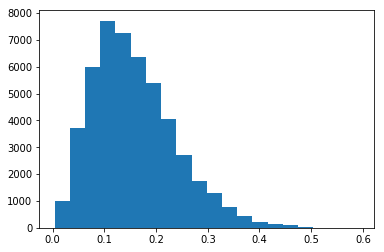

In [2]:
data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]

toss = pm.Uniform('toss', lower=0, upper=1)
coin = pm.Bernoulli('coin', p=toss, value=data, observed=True)
mcmc = pm.MCMC([toss, coin])
mcmc.sample(50000, 1000)
plt.hist(mcmc.trace("toss")[:], bins = 20)
plt.show()

# A/B Testing

Let's say that we have following obervations:

* In target group 20 customers churned from 500.
* In control group 70 customers churned from 1000.

Is this significant impact?

Shuffling might be usefull in this case.

In [3]:
target = np.append(np.zeros(480), np.ones(20))
control = np.append(np.zeros(930), np.ones(70))

target_conv = pm.Uniform('target_conv', lower=0, upper=1)
control_conv = pm.Uniform('control_conv', lower=0, upper=1)

@pm.deterministic
def delta(target_conv=target_conv, control_conv=control_conv):
    return control_conv - target_conv

target_obs = pm.Bernoulli("target_obs", target_conv, value = target, observed = True)
control_obs = pm.Bernoulli("control_obs", control_conv, value = control, observed = True)

mcmc = pm.MCMC([target_conv, control_conv, delta, target_obs, control_obs])
mcmc.sample(50000, 1000)

 [-----------------100%-----------------] 50000 of 50000 complete in 5.7 sec

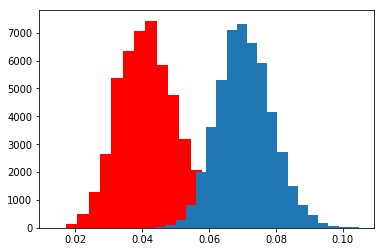

In [4]:
plt.hist(mcmc.trace("target_conv")[:], bins = 20, color = 'red')
plt.hist(mcmc.trace("control_conv")[:], bins = 20)
plt.show()

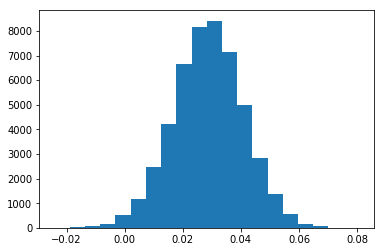

In [5]:
plt.hist(mcmc.trace("delta")[:], bins = 20)
plt.show()

In [6]:
np.mean(mcmc.trace("delta")[:] < 0)

0.010836734693877552

## Shuffling vs. Bayesian way

Let's see what happens if we take smaller numbers.

Impact on churn rate: -0.003


/home/trokas/anaconda3/envs/ai_primer/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


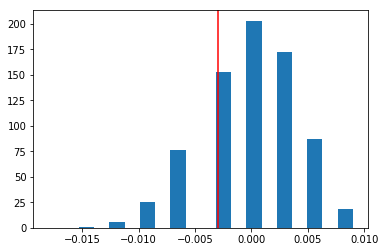

Probability that this is due to random event: 14.4730%


In [7]:
target = np.append(np.zeros(498), np.ones(2))
control = np.append(np.zeros(993), np.ones(7))

data = np.append(target, control)
split = target.shape[0]
expected = np.sum(target)/target.shape[0] - np.sum(control)/control.shape[0]
print("Impact on churn rate: {0}".format(expected))
rates = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    rates = np.append(rates, np.sum(permuted[split:])/permuted[split:].shape[0] - np.sum(permuted[:split])/split)
plt.hist(rates, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(rates < expected)))

 [-----------------100%-----------------] 50000 of 50000 complete in 5.1 sec

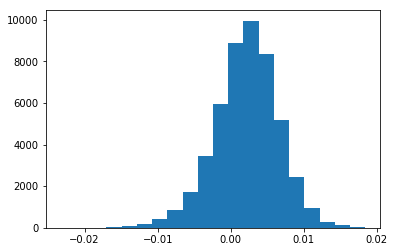

0.2873061224489796


In [8]:
target_conv = pm.Uniform('target_conv', lower=0, upper=1)
control_conv = pm.Uniform('control_conv', lower=0, upper=1)
@pm.deterministic
def delta(target_conv=target_conv, control_conv=control_conv):
    return control_conv - target_conv
target_obs = pm.Bernoulli("target_obs", target_conv, value = target, observed = True)
control_obs = pm.Bernoulli("control_obs", control_conv, value = control, observed = True)
mcmc = pm.MCMC([target_conv, control_conv, delta, target_obs, control_obs])
mcmc.sample(50000, 1000)
plt.hist(mcmc.trace("delta")[:], bins = 20)
plt.show()
print(np.mean(mcmc.trace("delta")[:] < 0))

It is easy to see that shuffling yelds same results as pymc, but it takes longer to perform simulations and results are less reliable. **Note that red line resembles zero in pyms plots.**